# Modelos generativos de texto

Veremos passo-a-passo como usar um modelo generativo de texto do Hugginface. Veremos dois tipos de modelos:

1. Modelos treinados apenas para completar textos
2. Modelos refinados para conversa com o usuário

É importante salientar que a biblioteca Hugginface possui os chamados *pipelines*, que permitem fazer o que veremos neste notebook de forma mais fácil. Mas pipelines abstraem totalmente os passos intermediários do processo.

### Modelo de geração de texto Llama

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

device = "cuda"

# Outros modelos possíveis:
#'meta-llama/Llama-3.2-3B'
#'meta-llama/Llama-3.1-8B'
#'meta-llama/Llama-3.1-70B'
#'meta-llama/Llama-3.1-405B'
name = "meta-llama/Llama-3.2-1B"

# O uso da biblioteca bitsandbytes permite a quantização dos pesos para reduzir uso de memória
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    name, 
    torch_dtype=torch.bfloat16,  # Precisão para criar o modelo antes de carregar os pesos
    device_map="auto",           # Carrega os pesos na GPU até o limite de memória. Se precisar 
                                 # de mais memória, o restante do modelo é carregado na CPU.
    quantization_config=quantization_config   # Estratégia de quantização
    )
tokenizer = AutoTokenizer.from_pretrained(
    name, 
    padding_side="left"         # Onde inserir o token de padding para criar batches de entrada
    )

# O modelo llama não foi treinado com um token de padding, mas ele é necessário para a inferência
# utilizando batches. Podemos usar o token de final de sentença para representar o padding. Esse
# token não é utilizado na atenção do modelo, então não deve afetar a geração de texto.
tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.eos_token_id

In [ ]:
# Tokenização de duas sentenças de texto
texts = ["A list of colors: red, blue", "1, 2"]
model_inputs = tokenizer(texts, padding=True, return_tensors="pt").to(device)
model_inputs

{'input_ids': tensor([[128000,     32,   1160,    315,   8146,     25,   2579,     11,   6437],
        [128001, 128001, 128001, 128001, 128000,     16,     11,    220,     17]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1]], device='cuda:0')}

In [3]:
# Decodificação dos tokens. Note que tokens extra foram adicionados para indicar o começo do texto,
# o fim do texto e o padding
tokenizer.batch_decode(model_inputs["input_ids"])

['<|begin_of_text|>A list of colors: red, blue',
 '<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|begin_of_text|>1, 2']

In [ ]:
# A primeira camada do modelo é a camada de embedding. Ela transforma cada um dos 128k tokens 
# possíveis em um vetor possuindo 2048 valores. Usualmente, modelos treinados apenas no idioma 
# inglês possuem em torno de 40k tokens. Modelos multilinguagem precisam de mais tokens para 
# representar palavras em diferentes idiomas.
model.model.embed_tokens

Embedding(128256, 2048)

In [5]:
embeddings = model.model.embed_tokens(model_inputs["input_ids"])
embeddings.shape
# Saída possui tamanho bs x nro de tokens x d_model

torch.Size([2, 9, 2048])

In [6]:
# Aplicação do modelo
output = model(**model_inputs)
output = output["logits"]
output.shape
# Saída possui tamanho bs x nro de tokens x n_vocab

torch.Size([2, 9, 128256])

A saída do modelo pode ser interpretada se seguinte forma. O vetor `output[0, i]` possui 128256 valores associados com os tokens de 0 a i-1 da sentença de entrada. Esse vetor representa os scores gerados pelo modelo para cada um dos 128256 tokens do vocabulário. Quanto maior o valor do score, maior a chance de que o respectivo token apareça após os tokens de 0 a i-1.

A saída possui esse padrão pois é assim que o modelo é treinado. Os tokens de 0 a i-1 são usados para prever o token i, e a função loss é calculada para cada valor de i. Mas para a inferência precisamos apenas dos scores do último token:

In [7]:
next_token_logits = output[:, -1]
print(next_token_logits.shape)

torch.Size([2, 128256])


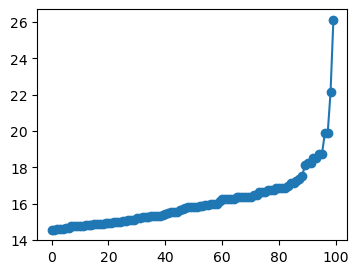

In [ ]:
import matplotlib.pyplot as plt

# Scores gerados para completar a sentença 0:
probs = next_token_logits[0]
probs = probs.detach().float().cpu().sort().values
plt.plot(probs[-100:], "-o")

In [ ]:
# Geração de texto. O modelo simplesmente encontra os tokens com maior probabilidade 
# de completar os tokens de entrada
# O resultado da geração consiste em "nro tokens de entrada + max_new_tokens".
# Veja https://huggingface.co/docs/transformers/en/generation_strategies para mais detalhes
# sobre as estratégias de geração
generated_ids = model.generate(**model_inputs, max_new_tokens = 20)
generated_ids

tensor([[128000,     32,   1160,    315,   8146,     25,   2579,     11,   6437,
             11,   6307,     11,  19087,     11,  14071,     11,  25977,     11,
          18718,     11,  14198,     11,   3776,     11,   4251,     11,   5099,
            627,     32],
        [128001, 128001, 128001, 128001, 128000,     16,     11,    220,     17,
             11,    220,     18,     11,    220,     19,     11,    220,     20,
             11,    220,     21,     11,    220,     22,     11,    220,     23,
             11,    220]], device='cuda:0')

In [10]:
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

['A list of colors: red, blue, green, orange, yellow, purple, pink, brown, black, white, etc.\nA',
 '1, 2, 3, 4, 5, 6, 7, 8, ']

Como o modelo gerou diversas palavras?

Para cada novo token a ser gerado, a sequência inteira é passada pelo modelo para gerar atributos para o **último token da sequência de saída**. Inicialmente, a sequência possui 9 tokens e um novo token é gerado. Para gerar o próximo token, o novo token é concatenado ao final da sequência, criando uma sequência de 10 tokens. Essa sequência é então a nova entrada do modelo, e o próximo token é gerado. O processo continua até que a sequência possua tamanho `max_new_tokens`.

### Modelo com refinamento de instrução

Modelos *instruct* foram treinados para conversação. O modelo gera palavras que representem uma conversa natural com o usuário

In [11]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Outros modelos possíveis:
#'meta-llama/Llama-3.2-3B-Instruct'
#'meta-llama/Llama-3.1-8B-Instruct'
#'meta-llama/Llama-3.1-70B-Instruct'
#'meta-llama/Llama-3.1-405B-Instruct'
name = "meta-llama/Llama-3.2-1B-Instruct"

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    name, 
    torch_dtype=torch.bfloat16,  
    device_map="auto",           
    quantization_config=quantization_config
    )
tokenizer = AutoTokenizer.from_pretrained(
    name
    )

tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.eos_token_id

Um modelo com instrução possui um template que indica como uma conversa deve ser formatada. Tipicamente, uma conversa possui os seguintes atores:

1. system: Texto que é adicionado no começo da conversa ou a **todas as entradas do usuário**. Tipicamente, esse texto envolve instruções de como o modelo deve se 'comportar' durante toda a conversa. 
2. user: Representa o usuário
3. assistant: Representa o modelo

A conversa também pode ter artefatos como ferramentas (tools) e documentos. Esses artefatos não serão vistos neste notebook.

Uma conversa é representada por um conjunto de mensagens, que são transformadas em uma única string:

In [12]:
# Exemplo de instrução de sistema e mensagem do usuário
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {
        "role": "user", 
        "content": "How many cats does it take to change a light bulb?"
    },
]

# Conversão da conversa em uma string
model_inputs = tokenizer.apply_chat_template(
    messages, 
    tokenize=False,
    add_generation_prompt=True   # Adiciona o texto assistant ao final da string para guiar o modelo
    )
print(model_inputs)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 08 Jun 2025

You are a friendly chatbot who always responds in the style of a pirate<|eot_id|><|start_header_id|>user<|end_header_id|>

How many cats does it take to change a light bulb?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




A string gerada acima possui um cabeçalho (system) com instruções para guiar o modelo, incluindo a data que o modelo foi treinado e a data atual, para que o modelo possa responder adequadamente perguntas que ultrapassem a data de treinamento.

A lista de mensagens é transformada em uma string através de um template Jinja:

In [13]:
print(tokenizer.chat_template)

{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{{- "Cutting Knowledge Date: December 2023\n" }}
{{- 

In [14]:
# Criação dos tokens para entrada no modelo
model_inputs = tokenizer.apply_chat_template(
    messages, 
    add_generation_prompt=True, 
    return_tensors="pt",
    return_dict=True,
    )
model_inputs

{'input_ids': tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   2318,  12044,    220,   2366,     20,    271,   2675,    527,
            264,  11919,   6369,   6465,    889,   2744,  31680,    304,    279,
           1742,    315,    264,  55066, 128009, 128006,    882, 128007,    271,
           4438,   1690,  19987,   1587,    433,   1935,    311,   2349,    264,
           3177,  46912,     30, 128009, 128006,  78191, 128007,    271]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [15]:
generated_ids = model.generate(**model_inputs.to(device), do_sample=True, max_new_tokens=50)
generated_ids

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   2318,  12044,    220,   2366,     20,    271,   2675,    527,
            264,  11919,   6369,   6465,    889,   2744,  31680,    304,    279,
           1742,    315,    264,  55066, 128009, 128006,    882, 128007,    271,
           4438,   1690,  19987,   1587,    433,   1935,    311,   2349,    264,
           3177,  46912,     30, 128009, 128006,  78191, 128007,    271,   9014,
            637,     11,    430,    387,    264,    436,   3390,     11,  30276,
             88,      0,    358,    387,   1781,    258,      6,    433,    387,
            264,  28799,  14397,     11,    719,    358,    387,   1390,    258,
              6,    311,   1440,    279,   4320,     13,   2650,   1690,  19987,
            656,  20043,   1781,    387,   1205,    258,      6,    311,   2349,
            264,   3177,  46

A saída do modelo inclui a entrada e os `max_new_tokens` gerados. Para obter apenas a saída, decodificamos apenas os novos tokens gerados:

In [16]:
input_length = model_inputs["input_ids"].shape[1]
generated_ids[:, input_length:]
print(tokenizer.decode(generated_ids[0, input_length:]))

Arrrr, that be a riddle, matey! I be thinkin' it be a clever trick, but I be wantin' to know the answer. How many cats do ye think be needin' to change a light bulb,
